In [1]:
"""
Enhanced Synthetic Data Generator with improved performance, maintainability, and flexibility.
Supports both DataFrame input and file-based processing with efficient memory management.
"""

'\nEnhanced Synthetic Data Generator with improved performance, maintainability, and flexibility.\nSupports both DataFrame input and file-based processing with efficient memory management.\n'

In [2]:
import json
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

from pathlib import Path
from typing import Union, List, Optional, Dict, Any
from dataclasses import dataclass, field
from contextlib import contextmanager
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

In [3]:
@dataclass
class SyntheticDataConfig:
    """Configuration class for synthetic data generation parameters."""
    
    # File paths
    seed_file: str = "final_agile_seed.csv"
    unique_category_file: str = "categories_unique_values.csv"
    data_folder: Path = field(default_factory=lambda: Path("../data"))
    config_folder: Path = field(default_factory=lambda: Path("../config"))
    
    # Processing parameters
    num_samples: int = 10000
    categorical_cols: List[str] = field(default_factory=list)
    
    # Output settings
    metadata_filename: str = "ISBSG2016_metadata_ALLCATEGORIES.json"
    output_filename: str = "synthetic_ISBSG2016R1_1_agile_SDV_generated.csv"
    
    def __post_init__(self):
        """Ensure paths are Path objects and directories exist."""
        self.data_folder = Path(self.data_folder)
        self.config_folder = Path(self.config_folder)
        self._ensure_directories()
    
    def _ensure_directories(self):
        """Create directories if they don't exist."""
        self.data_folder.mkdir(parents=True, exist_ok=True)
        self.config_folder.mkdir(parents=True, exist_ok=True)


class SyntheticDataProcessor:
    """
    High-performance synthetic data generator with flexible input handling.
    
    Features:
    - Memory efficient processing (no temporary DataFrames)
    - Flexible input (DataFrame or file path)
    - Comprehensive logging and error handling
    - Clean separation of concerns
    """
    
    def __init__(self, config: Optional[SyntheticDataConfig] = None):
        """
        Initialize the processor with configuration.
        
        Args:
            config: Configuration object. If None, uses default configuration.
        """
        self.config = config or SyntheticDataConfig()
        self.logger = self._setup_logging()
        self.metadata: Optional[SingleTableMetadata] = None
        self.synthesizer: Optional[GaussianCopulaSynthesizer] = None
    
    def _setup_logging(self) -> logging.Logger:
        """Configure logging for the processor."""
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger
    
    @contextmanager
    def _performance_timer(self, operation_name: str):
        """Context manager for timing operations."""
        import time
        start_time = time.time()
        self.logger.info(f"Starting {operation_name}...")
        try:
            yield
            elapsed = time.time() - start_time
            self.logger.info(f"✓ {operation_name} completed in {elapsed:.2f}s")
        except Exception as e:
            elapsed = time.time() - start_time
            self.logger.error(f"✗ {operation_name} failed after {elapsed:.2f}s: {e}")
            raise
    
    def load_data(self, source: Union[str, Path, pd.DataFrame]) -> pd.DataFrame:
        """
        Load data from various sources efficiently.
        
        Args:
            source: Can be a file path (str/Path) or pandas DataFrame
            
        Returns:
            pandas DataFrame with the loaded data
            
        Raises:
            ValueError: If source type is not supported
            FileNotFoundError: If file doesn't exist
        """
        if isinstance(source, pd.DataFrame):
            self.logger.info(f"Using provided DataFrame with {len(source)} rows")
            return source
        
        # Handle file path
        if isinstance(source, (str, Path)):
            file_path = Path(source)
            if not file_path.is_absolute():
                file_path = self.config.config_folder / file_path
            
            if not file_path.exists():
                raise FileNotFoundError(f"Data file not found: {file_path}")
            
            with self._performance_timer(f"Loading data from {file_path.name}"):
                # Use efficient CSV reading with optimal dtypes
                df = pd.read_csv(file_path, low_memory=False)
                self.logger.info(f"Loaded {len(df)} rows, {len(df.columns)} columns")
                return df
        
        raise ValueError(f"Unsupported source type: {type(source)}")
    
    def _optimize_dataframe_memory(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Optimize DataFrame memory usage without creating duplicates.
        
        Args:
            df: Input DataFrame to optimize
            
        Returns:
            Memory-optimized DataFrame (same object, modified in-place)
        """
        with self._performance_timer("Memory optimization"):
            initial_memory = df.memory_usage(deep=True).sum() / 1024**2
            
            # Optimize numeric columns
            for col in df.select_dtypes(include=['int64']).columns:
                col_min, col_max = df[col].min(), df[col].max()
                if col_min >= 0:
                    if col_max < 255:
                        df[col] = df[col].astype('uint8')
                    elif col_max < 65535:
                        df[col] = df[col].astype('uint16')
                    elif col_max < 4294967295:
                        df[col] = df[col].astype('uint32')
                else:
                    if col_min > -128 and col_max < 127:
                        df[col] = df[col].astype('int8')
                    elif col_min > -32768 and col_max < 32767:
                        df[col] = df[col].astype('int16')
                    elif col_min > -2147483648 and col_max < 2147483647:
                        df[col] = df[col].astype('int32')
            
            # Optimize float columns
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = pd.to_numeric(df[col], downcast='float')
            
            # Convert object columns to category where beneficial
            for col in df.select_dtypes(include=['object']).columns:
                if df[col].nunique() / len(df) < 0.5:  # Less than 50% unique values
                    df[col] = df[col].astype('category')
            
            final_memory = df.memory_usage(deep=True).sum() / 1024**2
            memory_reduction = (1 - final_memory/initial_memory) * 100
            self.logger.info(f"Memory reduced by {memory_reduction:.1f}% "
                           f"({initial_memory:.1f}MB → {final_memory:.1f}MB)")
        
        return df
    
    def generate_metadata(self, df: pd.DataFrame, save_path: Optional[Path] = None) -> SingleTableMetadata:
        """
        Generate and configure metadata for the DataFrame.
        
        Args:
            df: Input DataFrame
            save_path: Optional path to save metadata JSON
            
        Returns:
            Configured SingleTableMetadata object
        """
        with self._performance_timer("Metadata generation"):
            metadata = SingleTableMetadata()
            metadata.detect_from_dataframe(df)
            
            # Apply categorical column configurations
            categorical_updates = 0
            for col in self.config.categorical_cols:
                if col in df.columns:
                    metadata.update_column(column_name=col, sdtype='categorical')
                    categorical_updates += 1
            
            if categorical_updates > 0:
                self.logger.info(f"Updated {categorical_updates} columns as categorical")
            
            # Save metadata if path provided
            if save_path:
                save_path = Path(save_path)
                metadata.save_to_json(str(save_path), mode='overwrite')
                self.logger.info(f"Metadata saved to {save_path}")
            
            self.metadata = metadata
            return metadata
    
    def train_synthesizer(self, df: pd.DataFrame, metadata: Optional[SingleTableMetadata] = None) -> GaussianCopulaSynthesizer:
        """
        Train the Gaussian Copula synthesizer on the data.
        
        Args:
            df: Training DataFrame
            metadata: Optional metadata object. If None, uses stored metadata.
            
        Returns:
            Trained synthesizer
        """
        if metadata is None:
            if self.metadata is None:
                raise ValueError("No metadata available. Generate metadata first or provide it explicitly.")
            metadata = self.metadata
        
        with self._performance_timer("Synthesizer training"):
            synthesizer = GaussianCopulaSynthesizer(metadata)
            synthesizer.fit(df)
            self.synthesizer = synthesizer
            return synthesizer
    
    def generate_synthetic_data(self, num_samples: Optional[int] = None, 
                             synthesizer: Optional[GaussianCopulaSynthesizer] = None) -> pd.DataFrame:
        """
        Generate synthetic data using the trained synthesizer.
        
        Args:
            num_samples: Number of samples to generate. If None, uses config value.
            synthesizer: Optional synthesizer object. If None, uses stored synthesizer.
            
        Returns:
            DataFrame with synthetic data
        """
        if synthesizer is None:
            if self.synthesizer is None:
                raise ValueError("No synthesizer available. Train synthesizer first or provide it explicitly.")
            synthesizer = self.synthesizer
        
        if num_samples is None:
            num_samples = self.config.num_samples
        
        with self._performance_timer(f"Synthetic data generation ({num_samples:,} samples)"):
            synthetic_data = synthesizer.sample(num_samples)
            self.logger.info(f"Generated synthetic dataset: {synthetic_data.shape}")
            return synthetic_data
    
    def save_data(self, df: pd.DataFrame, file_path: Union[str, Path]) -> Path:
        """
        Save DataFrame to CSV file efficiently.
        
        Args:
            df: DataFrame to save
            file_path: Output file path
            
        Returns:
            Path object of the saved file
        """
        file_path = Path(file_path)
        if not file_path.is_absolute():
            file_path = self.config.data_folder / file_path
        
        with self._performance_timer(f"Saving data to {file_path.name}"):
            # Ensure parent directory exists
            file_path.parent.mkdir(parents=True, exist_ok=True)
            
            # Save with optimal parameters
            df.to_csv(file_path, index=False, compression='infer')
            file_size = file_path.stat().st_size / 1024**2
            self.logger.info(f"Saved {len(df):,} rows to {file_path} ({file_size:.1f}MB)")
        
        return file_path
    
    def process_complete_pipeline(self, source: Union[str, Path, pd.DataFrame], 
                                save_synthetic: bool = True) -> Dict[str, Any]:
        """
        Execute the complete synthetic data generation pipeline.
        
        Args:
            source: Data source (file path or DataFrame)
            save_synthetic: Whether to save synthetic data to file
            
        Returns:
            Dictionary containing results and metadata
        """
        results = {}
        
        try:
            # Load and optimize data
            df = self.load_data(source)
            df = self._optimize_dataframe_memory(df)
            results['original_data_shape'] = df.shape
            
            # Generate metadata
            metadata_path = self.config.config_folder / self.config.metadata_filename
            metadata = self.generate_metadata(df, metadata_path)
            results['metadata_path'] = str(metadata_path)
            
            # Train synthesizer
            synthesizer = self.train_synthesizer(df, metadata)
            
            # Generate synthetic data
            synthetic_data = self.generate_synthetic_data()
            results['synthetic_data_shape'] = synthetic_data.shape
            results['synthetic_data'] = synthetic_data
            
            # Save synthetic data if requested
            if save_synthetic:
                output_path = self.save_data(synthetic_data, self.config.output_filename)
                results['output_path'] = str(output_path)
            
            self.logger.info("✓ Complete pipeline executed successfully")
            return results, synthetic_data
            
        except Exception as e:
            self.logger.error(f"Pipeline execution failed: {e}")
            raise

In [4]:
def main():
    """Example usage of the SyntheticDataProcessor."""
    
    # Configure the processor
    config = SyntheticDataConfig(
        seed_file="final_agile_seed.csv",
        num_samples=10000,
        categorical_cols=[],  # Add your categorical columns here
    )
    
    # Initialize processor
    processor = SyntheticDataProcessor(config)
    
    # Run complete pipeline
    try:
        results, df_synthetic = processor.process_complete_pipeline(config.seed_file)
        print(f"\n=== PIPELINE COMPLETED SUCCESSFULLY ===")
        print(f"Original data shape: {results['original_data_shape']}")
        print(f"Synthetic data shape: {results['synthetic_data_shape']}")
        print(f"Output saved to: {results.get('output_path', 'Not saved')}")
        return df_synthetic
        
    except Exception as e:
        print(f"Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None


In [5]:

if __name__ == "__main__":
   df_synthetic = main()

2025-06-02 21:28:00,769 - __main__ - INFO - Starting Loading data from final_agile_seed.csv...
2025-06-02 21:28:00,834 - __main__ - INFO - Loaded 3861 rows, 159 columns
2025-06-02 21:28:00,835 - __main__ - INFO - ✓ Loading data from final_agile_seed.csv completed in 0.07s
2025-06-02 21:28:00,836 - __main__ - INFO - Starting Memory optimization...
2025-06-02 21:28:00,901 - __main__ - INFO - Memory reduced by 80.0% (4.5MB → 0.9MB)
2025-06-02 21:28:00,902 - __main__ - INFO - ✓ Memory optimization completed in 0.07s
2025-06-02 21:28:00,903 - __main__ - INFO - Starting Metadata generation...
2025-06-02 21:28:01,021 - __main__ - INFO - Metadata saved to ..\config\ISBSG2016_metadata_ALLCATEGORIES.json
2025-06-02 21:28:01,022 - __main__ - INFO - ✓ Metadata generation completed in 0.12s
2025-06-02 21:28:01,023 - __main__ - INFO - Starting Synthesizer training...
C:\Users\jdche\.conda\envs\pycaret311\Lib\site-packages\sdv\single_table\base.py:145: FutureWarning: The 'SingleTableMetadata' is depr


=== PIPELINE COMPLETED SUCCESSFULLY ===
Original data shape: (3861, 159)
Synthetic data shape: (10000, 159)
Output saved to: ..\data\synthetic_ISBSG2016R1_1_agile_SDV_generated.csv


# Exploratory Data Analysis

## Data Overview

Dataset shape: (10000, 159)
First 5 rows:


,isbsg_project_id,project_prf_year_of_project,external_eef_industry_sector,tech_tf_primary_programming_language,project_prf_functional_size,project_prf_normalised_work_effort_level_1,project_prf_normalised_work_effort,project_prf_normalised_level_1_pdr_ufp,project_prf_normalised_pdr_ufp,project_prf_speed_of_delivery,...,project_prf_development_type_not_defined,tech_tf_development_platform_hand_held,project_prf_relative_size_xxxl,tech_tf_architecture_multi_tier_client_server,tech_tf_client_server_not_applicable,tech_tf_type_of_server_proprietary_midrange,project_prf_application_type_top_transaction/production system,project_prf_application_type_top_financial application area,project_prf_application_type_top_client-server,project_prf_application_type_top_customer billing/relationship management
0,26702,2014,manufacturing,pl/i,306,709,405,11.136001,9.700681,98.513863,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,32668,2015,medical & health care,siebel,18,3192,1604,46.664330,47.643230,7.555258,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2,24373,2015,insurance,pl/i,97,5408,5508,118.617653,129.114532,1.987838,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3,12390,2015,medical & health care,java,254,3612,7612,63.244305,45.649982,37.364906,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
4,32718,2014,medical & health care,java,92,8118,8748,100.224823,102.044640,24.796749,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


Last 5 rows:


,isbsg_project_id,project_prf_year_of_project,external_eef_industry_sector,tech_tf_primary_programming_language,project_prf_functional_size,project_prf_normalised_work_effort_level_1,project_prf_normalised_work_effort,project_prf_normalised_level_1_pdr_ufp,project_prf_normalised_pdr_ufp,project_prf_speed_of_delivery,...,project_prf_development_type_not_defined,tech_tf_development_platform_hand_held,project_prf_relative_size_xxxl,tech_tf_architecture_multi_tier_client_server,tech_tf_client_server_not_applicable,tech_tf_type_of_server_proprietary_midrange,project_prf_application_type_top_transaction/production system,project_prf_application_type_top_financial application area,project_prf_application_type_top_client-server,project_prf_application_type_top_customer billing/relationship management
9995,12729,2008,financial,pl/i,194,9105,14330,106.244408,112.878197,5.766078,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
9996,31166,2006,mining,c_lang,332,5123,9899,5.276229,6.450372,39.327496,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
9997,17234,2015,insurance,java,105,3787,1917,40.845215,27.973942,15.762124,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
9998,21881,2000,government,pl/i,77,3673,4698,123.681549,112.222519,1.232115,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
9999,20341,2012,government,c_lang,199,6229,2500,16.686850,8.098407,37.300655,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


## Duplicate Rows

Number of duplicate rows: 0


## Data Types and Memory Usage

,Data Type,Memory Usage (MB)
Index,NaN,0.000126
external_eef_data_quality_rating_a,bool,0.009537
external_eef_data_quality_rating_b,bool,0.009537
external_eef_data_quality_rating_c_lang,bool,0.009537
external_eef_data_quality_rating_d,bool,0.009537
...,...,...
tech_tf_type_of_server_standalone,bool,0.009537
tech_tf_type_of_server_unix,bool,0.009537
tech_tf_type_of_server_webserver,bool,0.009537
tech_tf_web_development_nan,bool,0.009537


## Unique Values Per Column

isbsg_project_id: 3571 unique values
project_prf_year_of_project: 27 unique values
external_eef_industry_sector: 16 unique values
tech_tf_primary_programming_language: 73 unique values
project_prf_functional_size: 1087 unique values
project_prf_normalised_work_effort_level_1: 5612 unique values
project_prf_normalised_work_effort: 5738 unique values
project_prf_normalised_level_1_pdr_ufp: 10000 unique values
project_prf_normalised_pdr_ufp: 10000 unique values
project_prf_speed_of_delivery: 9999 unique values
project_prf_project_elapsed_time: 9999 unique values
project_prf_team_size_group: 15 unique values
project_prf_max_team_size: 9999 unique values
process_pmf_development_methodologies: 1 unique values
process_pmf_docs: 21 unique values
tech_tf_client_roles: 2 unique values
tech_tf_server_roles: 71 unique values
tech_tf_tools_used: 11 unique values
project_prf_cost_currency: 1 unique values
project_prf_application_group_business_application: 2 unique values
project_prf_application_gro

## Type Conversion Suggestions

No obvious candidates for 'category' dtype conversion.


## Summary Statistics

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isbsg_project_id,10000.000000,nan,nan,nan,21344.060000,6580.589180,10003.000000,15631.000000,21296.000000,26949.500000,32767.000000
project_prf_year_of_project,10000.000000,nan,nan,nan,2010.676800,5.882245,1989.000000,2009.000000,2013.000000,2015.000000,2015.000000
external_eef_industry_sector,8929,16,government,1733,nan,nan,nan,nan,nan,nan,nan
tech_tf_primary_programming_language,10000,73,java,3655,nan,nan,nan,nan,nan,nan,nan
project_prf_functional_size,10000.000000,nan,nan,nan,226.909600,264.255151,2.000000,45.000000,136.000000,311.000000,2292.000000
project_prf_normalised_work_effort_level_1,10000.000000,nan,nan,nan,3686.950200,4563.841473,4.000000,627.750000,2044.500000,5021.250000,42794.000000
project_prf_normalised_work_effort,10000.000000,nan,nan,nan,4141.931800,5518.916146,2.000000,528.000000,2069.000000,5580.250000,64834.000000
project_prf_normalised_level_1_pdr_ufp,10000.000000,nan,nan,nan,36.636353,43.814064,0.100024,6.877582,21.459283,50.316689,493.986816
project_prf_normalised_pdr_ufp,10000.000000,nan,nan,nan,37.095146,45.911728,0.100012,6.271461,20.480635,50.832414,524.984314
project_prf_speed_of_delivery,10000.000000,nan,nan,nan,33.182915,35.954086,0.000004,7.862614,21.181595,46.057614,293.087952


## Missing Values

,Missing Values,Percentage (%)
tech_tf_client_roles,9998,99.980000
project_prf_cost_currency,9994,99.940000
project_prf_application_type_top_transaction/production system,9861,98.610000
project_prf_application_type_top_financial application area,9812,98.120000
project_prf_application_type_top_client-server,9804,98.040000
project_prf_application_type_top_customer billing/relationship management,9780,97.800000
tech_tf_clientserver_description,3839,38.390000
external_eef_industry_sector,1071,10.710000
tech_tf_development_platform_hand_held,353,3.530000
project_prf_application_type_top_management of licences and permits,269,2.690000


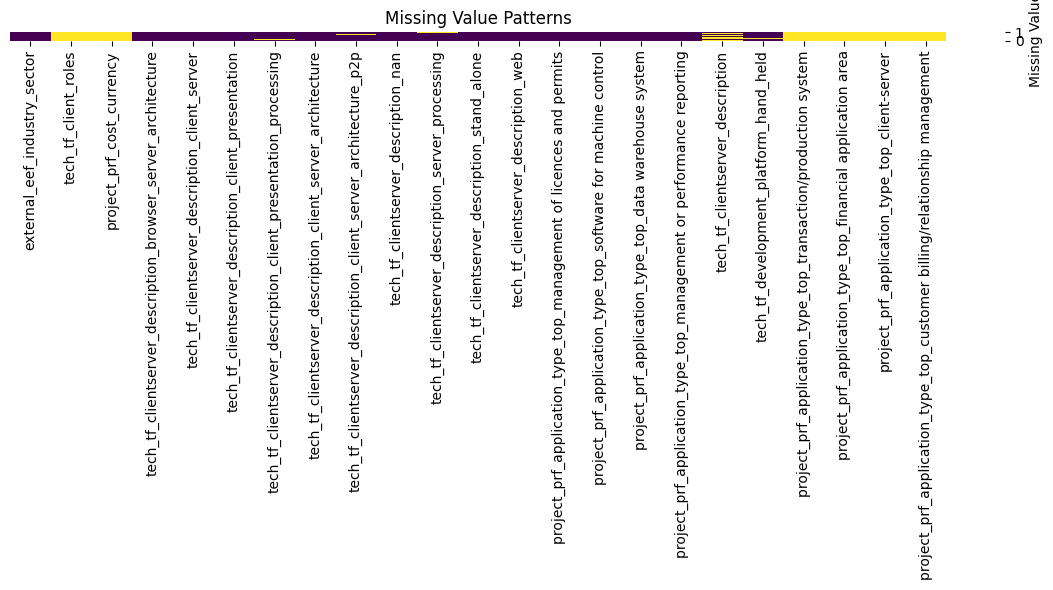

## Categorical Features

C:\Users\jdche\AppData\Local\Temp\ipykernel_36544\3920023567.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


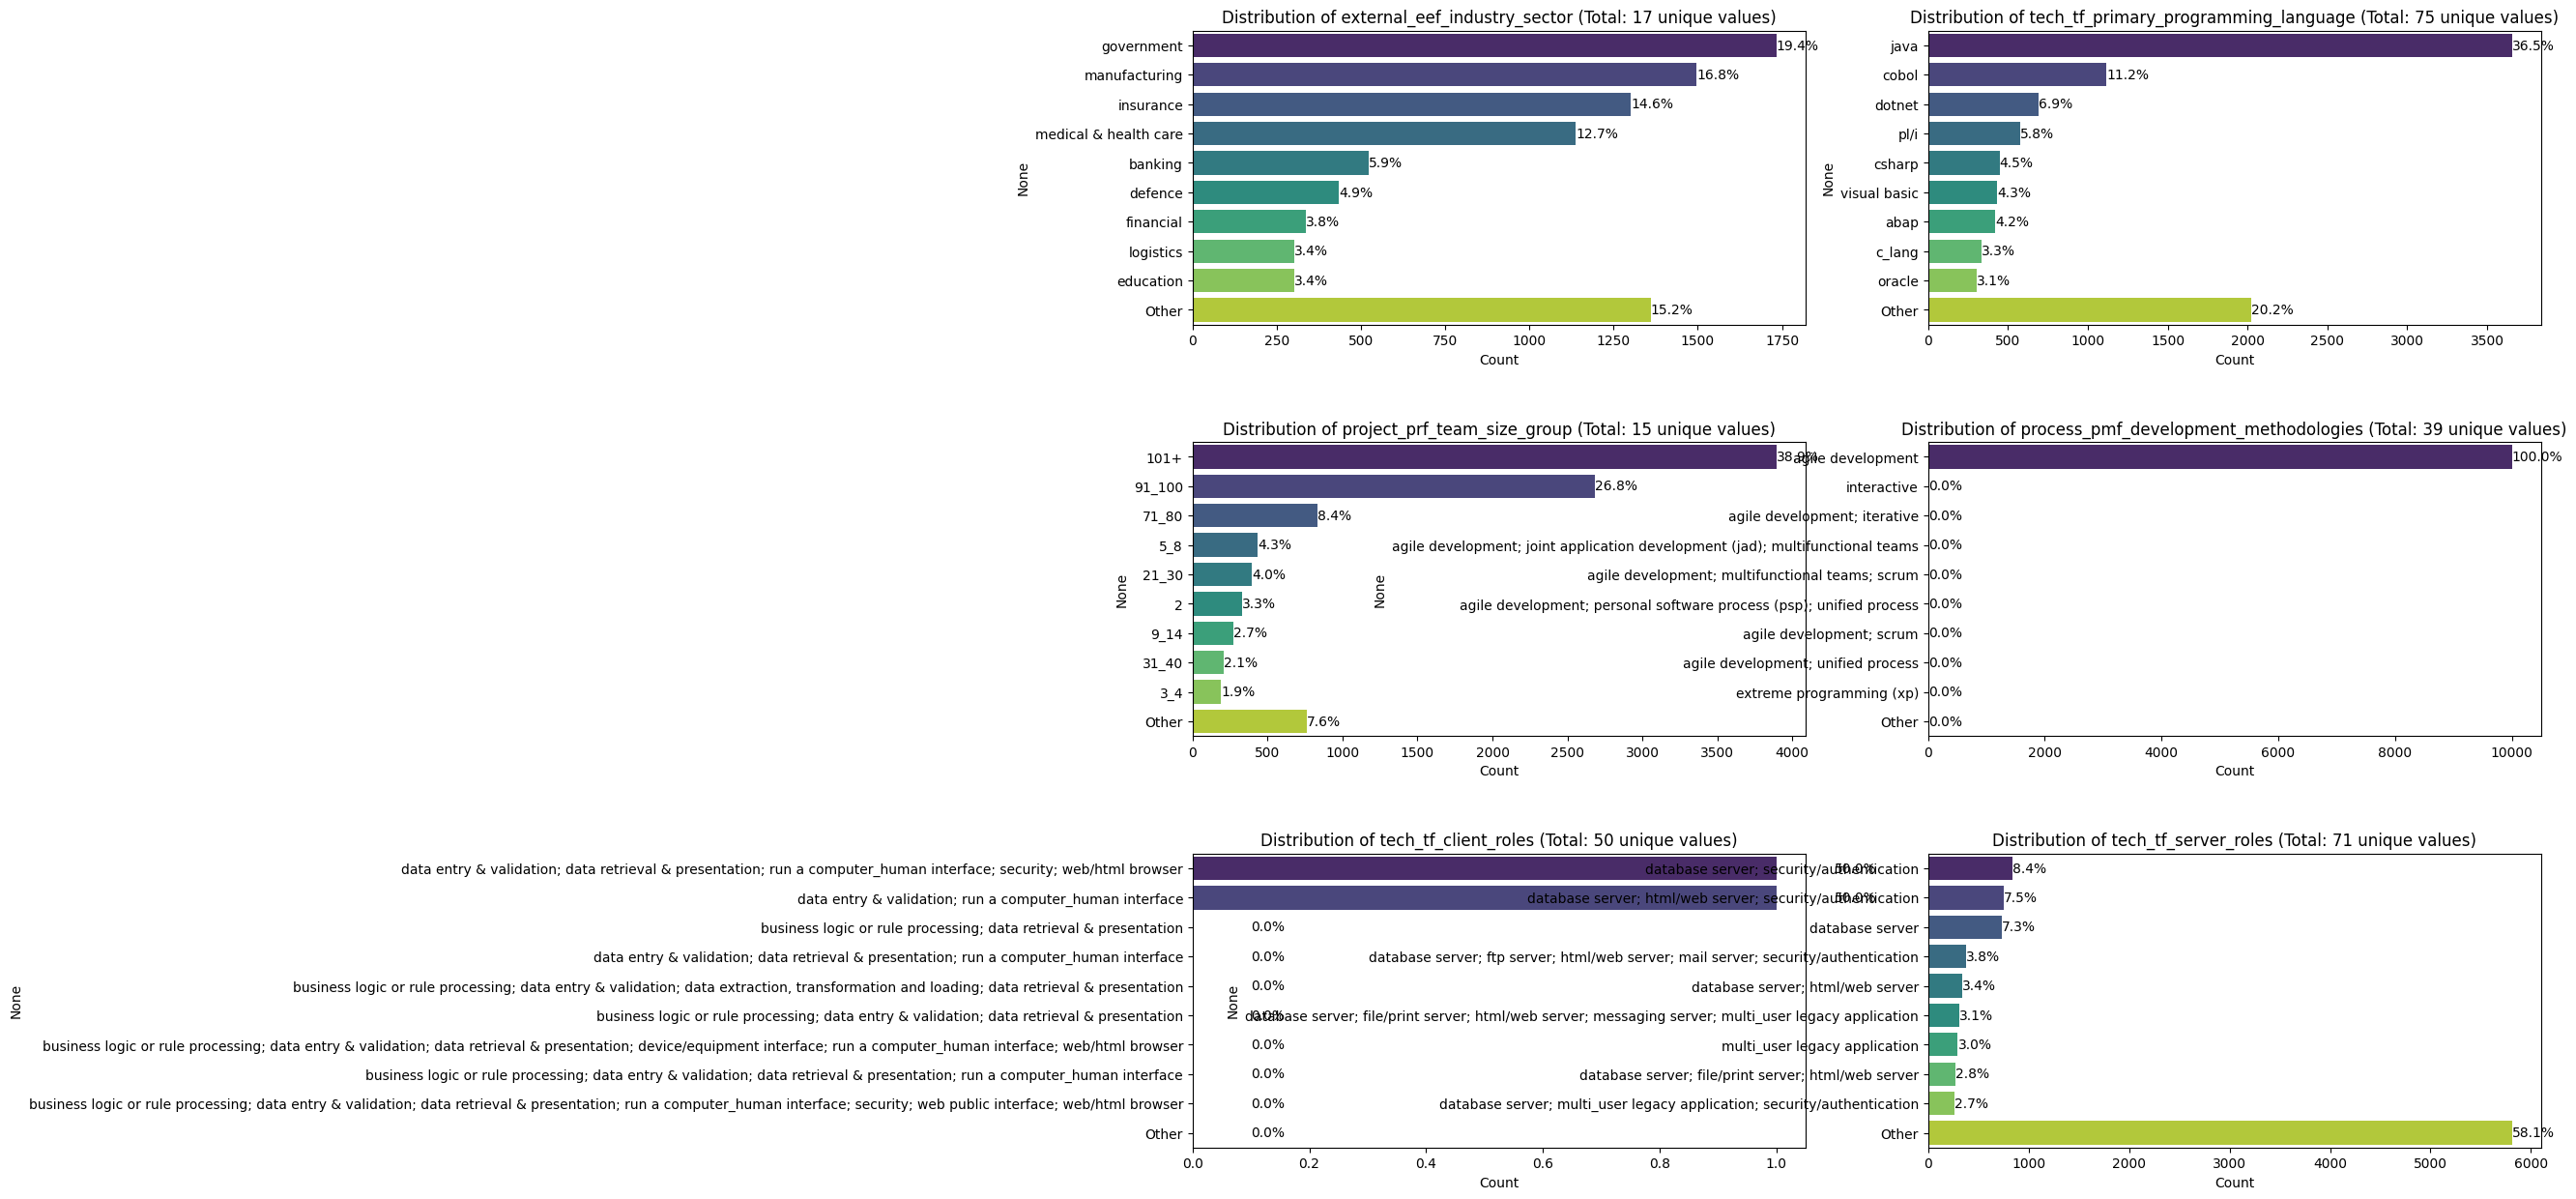

In [7]:
# Step 2: Explore the data

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def display_header(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"# {text}"))
    except ImportError:
        print(f"\n=== {text} ===\n")

def display_subheader(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"## {text}"))
    except ImportError:
        print(f"\n-- {text} --\n")

def explore_data(df: pd.DataFrame) -> None:
    """
    Perform exploratory data analysis on the input DataFrame with nicely aligned plots.
    Args:
        df: Input DataFrame
    """
    from IPython.display import display

    display_header("Exploratory Data Analysis")
    
    # Data Overview
    display_subheader("Data Overview")
    print(f"Dataset shape: {df.shape}")
    if df.shape[0] > 20:
        print("First 5 rows:")
        display(df.head())
        print("Last 5 rows:")
        display(df.tail())
    else:
        display(df)
    
    # Duplicate Row Checking
    display_subheader("Duplicate Rows")
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Data Types and Memory Usage
    display_subheader("Data Types and Memory Usage")
    dtype_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Memory Usage (MB)': df.memory_usage(deep=True) / 1024 / 1024
    })
    display(dtype_info)
    
    # Unique Values Per Column
    display_subheader("Unique Values Per Column")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # Type Conversion Suggestions
    display_subheader("Type Conversion Suggestions")
    potential_cat = [
        col for col in df.select_dtypes(include=['object']).columns
        if df[col].nunique() < max(30, 0.05*df.shape[0])
    ]
    if potential_cat:
        print("Consider converting to 'category' dtype for memory/performance:")
        print(potential_cat)
    else:
        print("No obvious candidates for 'category' dtype conversion.")
    
    # Summary Statistics
    display_subheader("Summary Statistics")
    try:
        display(df.describe(include='all').T.style.background_gradient(cmap='Blues', axis=1))
    except Exception:
        display(df.describe(include='all').T)
    
    # Missing Values
    display_subheader("Missing Values")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent.round(2)
    })
    if missing.sum() > 0:
        display(missing_info[missing_info['Missing Values'] > 0]
                .sort_values('Missing Values', ascending=False)
                .style.background_gradient(cmap='Reds'))
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        cols_with_missing = missing_info[missing_info['Missing Values'] > 0].index
        if len(cols_with_missing) > 0:
            sns.heatmap(df[cols_with_missing].isnull(), 
                        cmap='viridis', 
                        yticklabels=False, 
                        cbar_kws={'label': 'Missing Values'})
            plt.title('Missing Value Patterns')
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values in the dataset.")
    
    # Numerical Distributions
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if len(numerical_cols) > 0:
        display_subheader("Distribution of Numerical Features")
        sample_cols = numerical_cols[:min(12, len(numerical_cols))]
        num_cols = len(sample_cols)
        num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up
        fig = plt.figure(figsize=(18, num_rows * 4))
        grid = plt.GridSpec(num_rows, 3, figure=fig, hspace=0.4, wspace=0.3)
        for i, col in enumerate(sample_cols):
            row, col_pos = divmod(i, 3)
            ax = fig.add_subplot(grid[row, col_pos])
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='skyblue', alpha=0.7)
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            stats_text = (f"Std: {df[col].std():.2f}\n"
                          f"Min: {df[col].min():.2f}\n"
                          f"Max: {df[col].max():.2f}")
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)
            ax.set_title(f'Distribution of {col}')
            ax.legend(fontsize='small')
        plt.tight_layout()
        plt.show()
        # Correlation matrix and top correlations
        if len(numerical_cols) > 1:
            display_subheader("Correlation Matrix")
            corr = df[numerical_cols].corr().round(2)
            mask = np.triu(np.ones_like(corr, dtype=bool))
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', 
                        fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, 
                        annot_kws={"size": 10})
            plt.title('Correlation Matrix (Lower Triangle Only)', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            # Top correlations
            if len(numerical_cols) > 5:
                corr_unstack = corr.unstack()
                corr_abs = corr_unstack.apply(abs)
                corr_abs = corr_abs[corr_abs < 1.0]
                highest_corrs = corr_abs.sort_values(ascending=False).head(15)
                display_subheader("Top Correlations")
                for (col1, col2), corr_val in highest_corrs.items():
                    actual_val = corr.loc[col1, col2]
                    print(f"{col1} — {col2}: {actual_val:.2f}")
                pairs_to_plot = [(idx[0], idx[1]) for idx in highest_corrs.index][:6]
                if pairs_to_plot:
                    fig = plt.figure(figsize=(18, 12))
                    grid = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
                    for i, (col1, col2) in enumerate(pairs_to_plot):
                        row, col_pos = divmod(i, 3)
                        ax = fig.add_subplot(grid[row, col_pos])
                        sns.regplot(x=df[col1], y=df[col2], ax=ax, scatter_kws={'alpha':0.5})
                        r_value = df[col1].corr(df[col2])
                        ax.set_title(f'{col1} vs {col2} (r = {r_value:.2f})')
                    plt.tight_layout()
                    plt.show()
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(categorical_cols) > 0:
        display_subheader("Categorical Features")
        sample_cat_cols = categorical_cols[:min(6, len(categorical_cols))]
        num_cat_cols = len(sample_cat_cols)
        num_cat_rows = (num_cat_cols + 1) // 2
        fig = plt.figure(figsize=(18, num_cat_rows * 5))
        grid = plt.GridSpec(num_cat_rows, 2, figure=fig, hspace=0.4, wspace=0.2)
        for i, col in enumerate(sample_cat_cols):
            row, col_pos = divmod(i, 2)
            ax = fig.add_subplot(grid[row, col_pos])
            value_counts = df[col].value_counts().sort_values(ascending=False)
            top_n = min(10, len(value_counts))
            if len(value_counts) > top_n:
                top_values = value_counts.head(top_n-1)
                other_count = value_counts.iloc[top_n-1:].sum()
                plot_data = pd.concat([top_values, pd.Series({'Other': other_count})])
            else:
                plot_data = value_counts
            sns.barplot(x=plot_data.values, y=plot_data.index, hue=plot_data.index, ax=ax, palette='viridis')
            ax.set_title(f'Distribution of {col} (Total: {len(value_counts)} unique values)')
            ax.set_xlabel('Count')
            total = plot_data.sum()
            for j, v in enumerate(plot_data.values):
                percentage = v / total * 100
                ax.text(v + 0.1, j, f'{percentage:.1f}%', va='center')
        plt.tight_layout()
        plt.show()
        # Categorical-numerical boxplots
        if numerical_cols and len(categorical_cols) > 0:
            display_subheader("Categorical-Numerical Relationships")
            numerical_variances = df[numerical_cols].var()
            target_numerical = numerical_variances.idxmax()
            sample_cat_for_box = [col for col in categorical_cols 
                                  if df[col].nunique() <= 15][:4]
            if sample_cat_for_box:
                fig = plt.figure(figsize=(18, 5 * len(sample_cat_for_box)))
                for i, cat_col in enumerate(sample_cat_for_box):
                    ax = fig.add_subplot(len(sample_cat_for_box), 1, i+1)
                    order = df.groupby(cat_col)[target_numerical].median().sort_values().index
                    sns.boxplot(x=cat_col, y=target_numerical, data=df, ax=ax, 
                                order=order, palette='viridis')
                    ax.set_title(f'{cat_col} vs {target_numerical}')
                    ax.set_xlabel(cat_col)
                    ax.set_ylabel(target_numerical)
                    plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()

# Exploratory Data Analysis
explore_data(df_synthetic)

